# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
device = torch.device('cpu')



In [3]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]

        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)

            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)

            image_array.append(array)

        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]

    def __repr__(self):
        return str(self.dataframe.head())


In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64)
print(dataset)

#upload model
model_path = path_to_project_root + 'models/brain_tumor_cnn.pt'
try:
    model = torch.load(model_path)
    model.eval()
except Exception:
    print('proceed with training')

                                         image  labels
0   ../../../data/brain_tumor_imgs/no\No16.jpg       0
1   ../../../data/brain_tumor_imgs/yes\Y98.JPG       1
2   ../../../data/brain_tumor_imgs/yes\Y31.jpg       1
3  ../../../data/brain_tumor_imgs/yes\Y182.JPG       1
4  ../../../data/brain_tumor_imgs/yes\Y242.JPG       1
proceed with training


#### MODEL with SyMPC wraper

In [6]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [7]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
plot = False

def train(model, dataset, num_epochs = 100, batch_size = 32):
    model.train()

    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        for i in range(len(dataset)//batch_size):
            optimizer.zero_grad()
            image, label = dataset[i*batch_size:(i+1)*batch_size]
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
        if epoch%10 == 0:
            print(f'Epochs: {epoch} Loss: {total_loss/i}')
        loss_list.append(total_loss/batch_size)
    return loss_list
loss_list = train(model, dataset, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

Epochs: 0 Loss: 3.296222686767578
Epochs: 10 Loss: 0.5272745490074158


#### ORIGINAL MODEL

In [ ]:
class BrainTumorModelOriginal(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,128,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(30,64)
        self.linear2 = nn.Linear(64,32)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(30720,2)
        # self.linear3 = nn.Linear(63488,2)

    def forward(self,x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.linear1(x))
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.linear3(x)

        return x

In [ ]:
model_orig = BrainTumorModelOriginal()
print(model_orig)

In [58]:

model_orig = BrainTumorModelOriginal()
epochs = 100
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):

        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model_orig.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')
        break
# in case decrease size in half

torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
torch.Size([32, 1, 64, 64])
torch.Size([32, 32, 30, 30])
torch.Size([32, 32, 30, 64])
torch.Size([32, 32, 30, 32])
torch.Size([32, 30720])
Epochs: 0 Loss: 1.739948153

tensor([[-1.1919,  1.2039]], grad_fn=<AddmmBackward>)
tensor([[-0.9501,  0.9367]], grad_fn=<AddmmBackward>)
tensor([[-1.4381,  1.4310]], grad_fn=<AddmmBackward>)
tensor([[-1.1919,  1.2039]], grad_fn=<AddmmBackward>)
tensor([[-1.2524,  1.2630]], grad_fn=<AddmmBackward>)
tensor([[-1.1993,  1.2117]], grad_fn=<AddmmBackward>)
tensor([[-1.1919,  1.2039]], grad_fn=<AddmmBackward>)
tensor([[-0.9539,  0.9601]], grad_fn=<AddmmBackward>)
tensor([[-0.4800,  0.4973]], grad_fn=<AddmmBackward>)
tensor([[-1.2192,  1.2299]], grad_fn=<AddmmBackward>)
tensor([[-0.4800,  0.4973]], grad_fn=<AddmmBackward>)
tensor([[-0.9998,  1.0088]], grad_fn=<AddmmBackward>)
tensor([[-1.1774,  1.1523]], grad_fn=<AddmmBackward>)
tensor([[-1.5163,  1.5125]], grad_fn=<AddmmBackward>)
tensor([[-1.1919,  1.2039]], grad_fn=<AddmmBackward>)
tensor([[-1.1919,  1.2039]], grad_fn=<AddmmBackward>)
tensor([[-1.1489,  1.1486]], grad_fn=<AddmmBackward>)
tensor([[-1.1919,  1.2039]], grad_fn=<AddmmBackward>)
tensor([[-1.0606,  1.0698]],

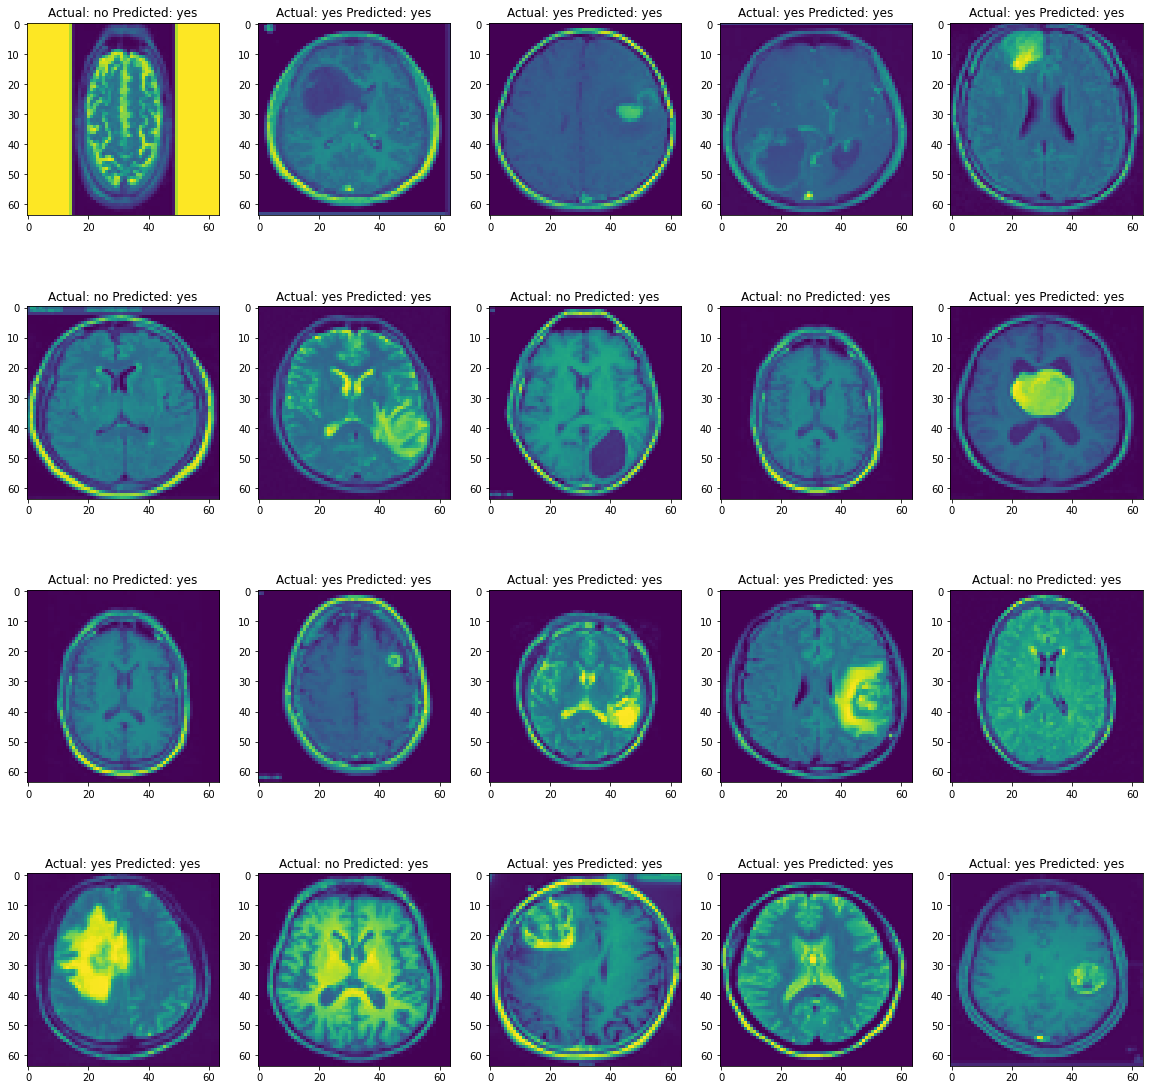

In [29]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model.forward(data.float())
    print(pred)
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()


#todo make accuracy


In [11]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [12]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    data_pointers = []

    split_size = int(len(data)/len(session.parties))+1
    for index in range(0,len(session.parties)):
        ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        data_pointers.append(ptr)

    return data_pointers

In [13]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [14]:
ptrs = []
labels = []
for i, (img, lbl) in enumerate(dataset):
    img_f = img.type(torch.float16)
    ptrs.append(img.share(session=session))
    labels.append(lbl)
    if i == 3: break
ptrs

[[MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: False
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]

In [25]:
dataset[0][0][0][0][0]

tensor([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        224,  12,   0,   2,   2,   1,   1,   1,   1,   3,   2,   0,   2,   9,
         17,  17,  18,  15,  24,  16,  14,  20,  25,  20,   6,   1,   2,   2,
          1,   1,   2,   2,   2,   0,  12, 225, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255], dtype=torch.uint8)

In [15]:
mpc_model = model.share(session)
mpc_model

In [16]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    plaintext_results = encrypted_results.reconstruct()
    results.append(plaintext_results)

end_time = time.time()
results

C:\Users\ollyt\anaconda3\envs\pysyft\lib\site-packages\sympc\protocol\fss\fss.py:140: UserWarning: Temporarily disabling CUDA as FSS does not support it
  warnings.warn("Temporarily disabling CUDA as FSS does not support it")
[2021-11-03T17:25:13.408588+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1762043c25e947ea95a9309c0c3e539e>.
[2021-11-03T17:25:13.416391+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76e1e82814a7431fbb0c5767b4256e8d>.
[2021-11-03T17:26:14.288259+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: efe3646b71ff476a92d924e5eaa8cd2f>.
[2021-11-03T17:26:14.291055+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 382771a2dab344edb34a2fa0b7ad4995>.
[2021-11-03T17:26:43.550072+0100][CRITICAL][logger]][14496] <class 'syft.core.store.store_memo

[tensor([[ 46.9139, -46.4241]]),
 tensor([[ 46.7628, -46.2344]]),
 tensor([[ 46.4838, -46.0815]]),
 tensor([[ 44.4079, -44.2572]])]

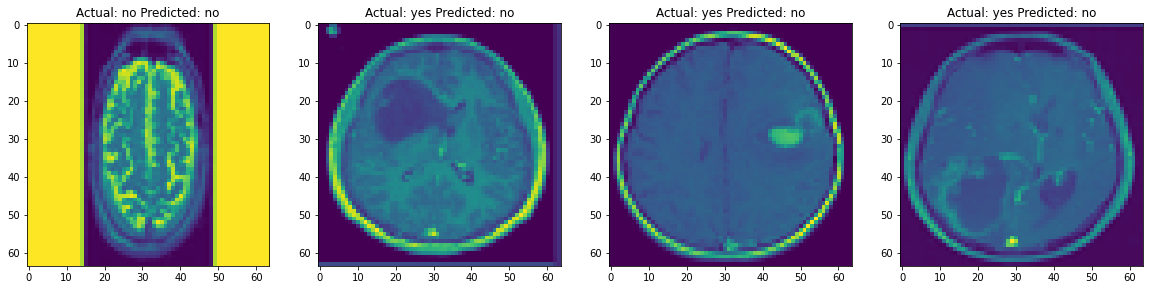

Time for inference: 414.4619450569153


In [28]:
fig = plt.figure(figsize=(20,20))
for i in range(4):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred,dim=1)
    plt.subplot(1,4,i+1)
    plt.imshow(dataset[i][0][0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")

In [60]:
predictions=inference(3, model)




TypeError: share() missing 1 required positional argument: 'session'